In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()

In [ ]:
# # Importing libraries
# from google.colab import drive
# import sys
# # Mount google drive
# drive.mount('/content/gdrive')
# # Changing path dirctory
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')


In [ ]:
# import os, sys

# from google.colab import drive
# drive.mount('/content/gdrive')

# #create a path to save the module
# nb_path = '/content/notebooks'
# os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)

In [ ]:
#  pip install --target=$nb_path serpapi

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [ ]:
import serpapi
serpapi_params = {
    "engine": "google",
    "api_key": ""
    # os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")
}

search = serpapi.search({
    **serpapi_params,
    "q": "coffee"
})

# results = search.get_dict()["organic_results"]
results = search["organic_results"]



In [ ]:
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)

In [ ]:
print(contexts)

Coffee
Coffee is a beverage brewed from roasted coffee beans. Darkly colored, bitter, and slightly acidic, coffee has a stimulating effect on humans, primarily due ...
https://en.wikipedia.org/wiki/Coffee
---
Peet's Coffee | The Original Craft Coffee, Est. 1966
Since 1966, Peet's Coffee has sourced and offered superior coffees and teas and adhering to strict high-quality and taste standards. Shop today.
https://www.peets.com/
---
Blue Bottle Coffee | Fresh Roasted Specialty Coffee
Blue Bottle Coffee is a specialty coffee roaster with cafes in LA, SF, NYC, & Japan. Shop our freshly roasted specialty coffee online & in-store.
https://bluebottlecoffee.com/?srsltid=AfmBOoq0BsVydAbQTKYnQrLP3ahlpPCLpnh6og1ViQCli72SdJa47meV
---
Starbucks Coffee Company
More than just great coffee. Explore the menu, sign up for Starbucks® Rewards, manage your gift card and more.
https://www.starbucks.com/
---
The Coffee Bean & Tea Leaf | CBTL
We're passionate about delivering the best handcrafted products and 

In [ ]:
from langchain.tools import tool # Import the tool decorator from langchain.tools

@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = serpapi.search({
        **serpapi_params,
        "q": query,
        "num": 1
    })
    results = search["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

In [ ]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])



In [ ]:
# pip install langchain_groq

In [ ]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature=0,
    groq_api_key='',
    # model_name="llama-3.1-70b-versatile"
    model="llama3-70b-8192"

)

tools=[
    # rag_search_filter,
    # rag_search,
    # fetch_arxiv,
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
         if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="auto")
)

In [ ]:
inputs = {
    "input": "tell me something about planets",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jas9', 'function': {'arguments': '{"query":"tell me something about planets"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 1433, 'total_tokens': 1470, 'completion_time': 0.115689417, 'prompt_time': 0.111686309, 'queue_time': 0.018927631000000014, 'total_time': 0.227375726}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-01ee1602-4749-40e4-b07e-dc7d1e285eee-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'tell me something about planets'}, 'id': 'call_jas9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1433, 'output_tokens': 37, 'total_tokens': 1470})

In [ ]:
out.tool_calls[0]["name"]

'web_search'

In [ ]:
out.tool_calls[0]["args"]

{'query': 'tell me something about planets'}

In [ ]:
def run_oracle(state):
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    # Check if tool_calls is not empty before accessing the first element
    if out.tool_calls:
        tool_name = out.tool_calls[0]["name"]
        tool_args = out.tool_calls[0]["args"]
        action_out = AgentAction(
            tool=tool_name,
            tool_input=tool_args,
            # log=str(out)
            log="TBD"
        )
        return {"intermediate_steps": [action_out]}
    else:
        # Handle the case where no tool is called (e.g., return a default value or raise an exception)
        return {"intermediate_steps": []} # Or handle it differently based on your needs

# def run_oracle(state: list):
#     print("run_oracle")
#     print(f"intermediate_steps: {state['intermediate_steps']}")
#     out = oracle.invoke(state)
#     tool_name = out.tool_calls[0]["name"]
#     tool_args = out.tool_calls[0]["args"]
#     action_out = AgentAction(
#         tool=tool_name,
#         tool_input=tool_args,
#         log="TBD"
#     )
#     return {
#         "intermediate_steps": [action_out]
#     }



def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

In [ ]:
tool_str_to_func = {
    # "rag_search_filter": rag_search_filter,
    # "rag_search": rag_search,
    # "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

In [ ]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
# graph.add_node("rag_search_filter", run_tool)
# graph.add_node("rag_search", run_tool)
# graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

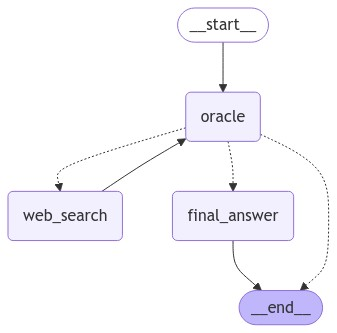

In [ ]:
# from IPython.display import Image

# Image(runnable.get_graph().draw_png())

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
out = runnable.invoke({
    "input": "tell me something about aliens",
    "chat_history": [],
})

intermediate_steps: []
web_search.invoke(input={'query': 'aliens'})
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'aliens'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'aliens'}, log='Aliens (film)\nAliens is a 1986 science fiction action film written and directed by James Cameron. It is the sequel to the 1979 science fiction horror film Alien\nhttps://en.wikipedia.org/wiki/Aliens_(film)')]
web_search.invoke(input={'query': 'aliens'})
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'aliens'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'aliens'}, log='Aliens (film)\nAliens is a 1986 science fiction action film written and directed by James Cameron. It is the sequel to the 1979 science fiction horror film Alien\nhttps://en.wikipedia.org/wiki/Aliens_(film)'), AgentAction(tool='web_search', tool_input={'query': 'aliens'}, log='Aliens (film)\nAliens is a 1986 science fiction action film written and

KeyboardInterrupt: 

In [ ]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))

In [ ]:
# Access the content of the AIMessage using the 'content' attribute
print(build_report(
    output=out["intermediate_steps"][-1].content.tool_input
))